In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import cv2
from torch.distributions.multivariate_normal import MultivariateNormal
import torch.nn.functional as F

In [2]:
device = torch.device("cuda:0")

In [4]:
test = plt.imread('/home/abeer/LL_data/test/1.jpg')
test = cv2.resize(test, dsize=(256,256))
test_gt = torch.tensor(test).permute(2,0,1).unsqueeze(0).to(device, dtype=torch.float)

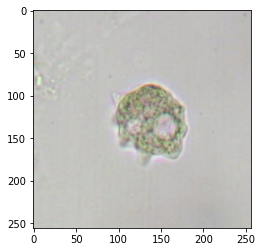

In [6]:
plt.imshow(test_gt[0].permute(1,2,0).detach().cpu()/255)

In [7]:
def psfconvolve_torch(inp, psf):
    r = torch.conv2d(inp[:,0,:,:], psf, padding='same')
    g = torch.conv2d(inp[:,1,:,:], psf, padding='same')
    b = torch.conv2d(inp[:,2,:,:], psf, padding='same')
    f = torch.stack((r[0],g[0],b[0])).permute(1,2,0)
    return f/f.max()

def gray(psf):
    graypsf = 0.299*psf[:,:,0] + 0.587*psf[:,:,1] + 0.114*psf[:,:,2]
    return graypsf

In [8]:
def psfconvolve_batch(ins, psf, batch):
    l=[]
    for i in range(batch):
        unit = psfconvolve_torch(ins[i].unsqueeze(0), psf).permute(2,0,1)
        l.append(unit)
    return torch.stack(l)

In [9]:
def loadpsf(path):
    psf = Image.open(path)
    psf = np.array(psf)
    psf = cv2.resize(psf, dsize=(500,500))
    psf = psf/psf.max()
    return psf

In [10]:
psf = loadpsf('/home/abeer/Desktop/psf/psf.jpg')
psf_256 = cv2.resize(gray(psf), dsize=(256,256))
psf_256 = torch.tensor(psf_256).permute(1,0).unsqueeze(0).unsqueeze(0).to(device, dtype=torch.float)

In [11]:
def contract(in_ch, out_ch, k_size, pad):
    contraction = nn.Sequential(
        torch.nn.Conv2d(in_ch, out_ch, kernel_size=k_size, stride=1, padding=pad),
        torch.nn.BatchNorm2d(out_ch),
        torch.nn.ReLU(),
        torch.nn.Conv2d(out_ch, out_ch, kernel_size=k_size, stride=1, padding=pad),
        torch.nn.BatchNorm2d(out_ch),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )
    
    return contraction

def expand(in_ch, out_ch, k_size, pad):
    expansion = nn.Sequential(
        torch.nn.Conv2d(in_ch, out_ch, kernel_size=k_size, stride=1, padding=pad),
        torch.nn.BatchNorm2d(out_ch),
        torch.nn.ReLU(),
        torch.nn.Conv2d(out_ch, out_ch, kernel_size=k_size, stride=1, padding=pad),
        torch.nn.BatchNorm2d(out_ch),
        torch.nn.ReLU(),
        torch.nn.UpsamplingNearest2d(scale_factor=2)
    )
    
    return expansion

In [12]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.d1 = expand(int(latent_dim),512,3,1) # --> out 2x2
        self.d2 = expand(512,256,3,1) # --> out 4x4
        self.d3 = expand(256,128,3,1) # --> out 8x8
        self.d4 = expand(128,64,3,1) # --> out 16x16
        self.d5 = expand(64,32,3,1) # --> out 32x32
        self.d6 = expand(32,16,3,1) # --> out 64x64
        self.d7 = expand(16,8,3,1) # --> out 128x128
        self.d8 = expand(8,3,3,1) # --> out 256x256
        
    def forward(self, c):
        t = self.d1(c)
        t = self.d2(t)
        t = self.d3(t)
        t = self.d4(t)
        t = self.d5(t)
        t = self.d6(t)
        t = self.d7(t)
        t = self.d8(t)
        return t

In [17]:
latent_dim = 256

In [18]:
optimized_latent_space = torch.load("opt_iter_30000_10_shot_ll_paramecium_l256.pt")
mean_latent_space = optimized_latent_space.mean(dim=0, keepdim=True)

In [22]:
def total_variation(img, weight):
    bs_img, c_img, h_img, w_img = img.size()
    tv_h = torch.pow(img[:,:,1:,:]-img[:,:,:-1,:], 2).sum()
    tv_w = torch.pow(img[:,:,:,1:]-img[:,:,:,:-1], 2).sum()
    return weight*(tv_h+tv_w)/(bs_img*c_img*h_img*w_img)

In [24]:
generator = Generator(latent_dim).to(device)
generator.load_state_dict(torch.load("pre_gen_30000iter_10_shot_ll_paramecium_l256.pt"))
generator.eval()

Generator(
  (d1): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
  )
  (d2): Sequential(
    (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
  )
  (d3): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), paddin

In [26]:
z = torch.tensor(mean_latent_space.cpu().detach().numpy(), device=device, dtype=torch.float32, requires_grad=True)

/home/abeer/anaconda3/envs/torchgpu/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:882.)
  


Epoch:  0
Loss:  0.008641211315989494


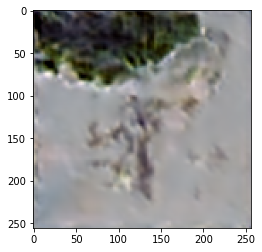

Epoch:  100
Loss:  0.00587884709239006


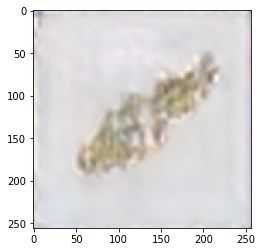

Epoch:  200
Loss:  0.005770835559815168


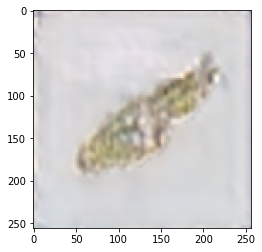

Epoch:  300
Loss:  0.005757154431194067


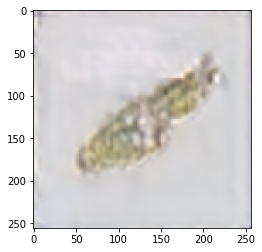

Epoch:  400
Loss:  0.005743060261011124


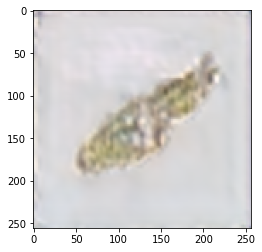

Epoch:  500
Loss:  0.00572960963472724


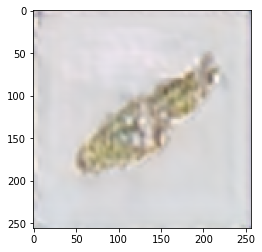

Epoch:  600
Loss:  0.005723923444747925


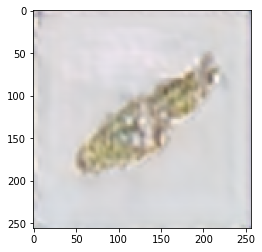

Epoch:  700
Loss:  0.005720627494156361


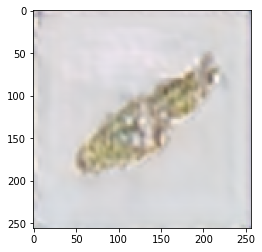

Epoch:  800
Loss:  0.005717063322663307


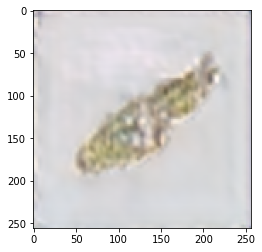

Epoch:  900
Loss:  0.0056977709755301476


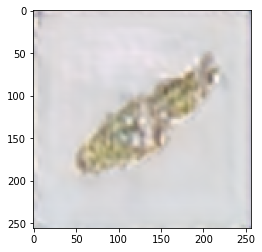

Epoch:  1000
Loss:  0.005659454967826605


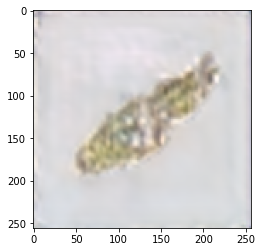

Epoch:  1100
Loss:  0.005640645977109671


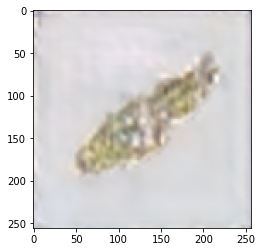

Epoch:  1200
Loss:  0.005629341118037701


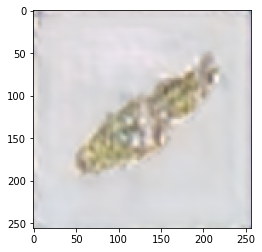

Epoch:  1300
Loss:  0.005620246287435293


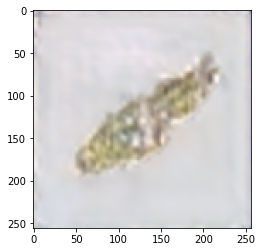

Epoch:  1400
Loss:  0.0056135645136237144


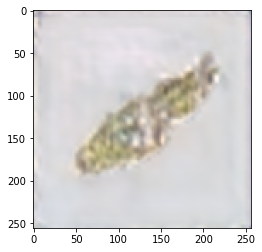

In [27]:

criterion = nn.L1Loss()
learning_rate = 1e-1
opt1 = torch.optim.Adam({z}, lr=learning_rate)
z = z.requires_grad_()
num_steps=1500
y_0 = psfconvolve_torch(test_gt, psf_256)
y_0 = torch.Tensor(y_0).permute(2,0,1).unsqueeze(0).to(device, dtype=torch.float)


for i in range(num_steps):
    opt1.zero_grad()
    loss = criterion(psfconvolve_torch(generator(z), psf_256).permute(2,0,1).unsqueeze(0), y_0)
    loss.backward()
    opt1.step()
    
    if i%100==0:
        im = generator(z)[0].permute(1,2,0).detach().cpu()
        print("Epoch: ", i)
        print("Loss: ", float(loss))
        plt.imshow(im/im.max())
        plt.show()

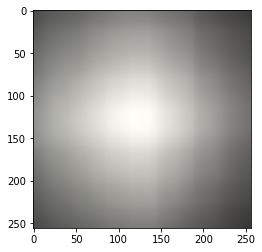

In [28]:
plt.imshow(y_0[0].permute(1,2,0).cpu().detach())

Epoch:  0
Loss:  0.00037943117786198854


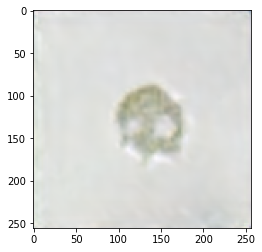

Epoch:  100
Loss:  0.00038345527718774974


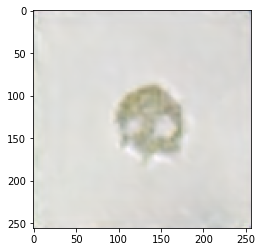

Epoch:  200
Loss:  0.00037863728357478976


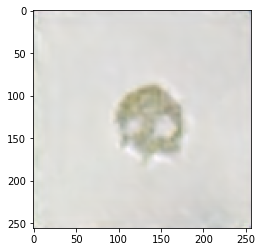

Epoch:  300
Loss:  0.00038160436088219285


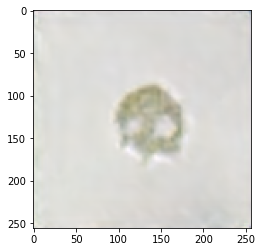

Epoch:  400
Loss:  0.000374724215362221


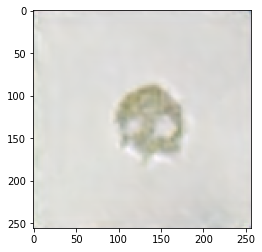

Epoch:  500
Loss:  0.0003829610941465944


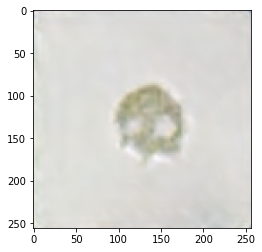

Epoch:  600
Loss:  0.0003490331000648439


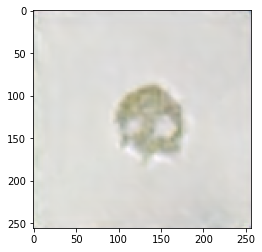

Epoch:  700
Loss:  0.0003611078136600554


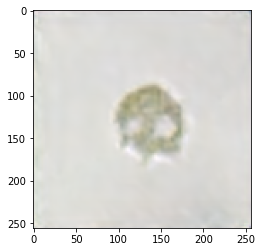

Epoch:  800
Loss:  0.00036108747008256614


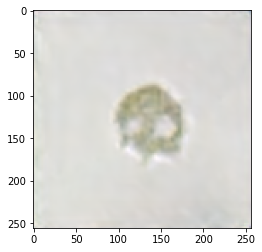

Epoch:  900
Loss:  0.0003772745840251446


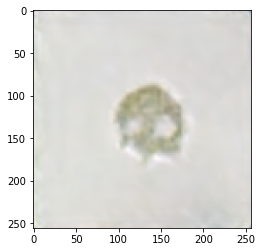

Epoch:  1000
Loss:  0.00036540470318868756


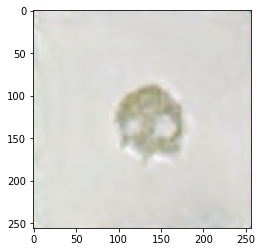

Epoch:  1100
Loss:  0.000381000863853842


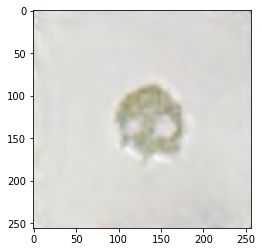

Epoch:  1200
Loss:  0.0003539710305631161


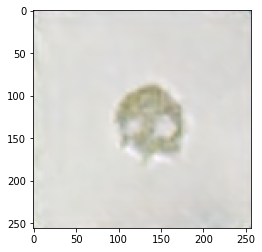

Epoch:  1300
Loss:  0.0003538859891705215


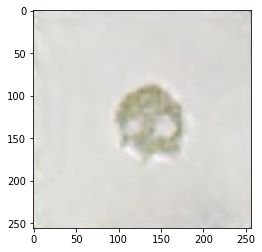

Epoch:  1400
Loss:  0.0003675125481095165


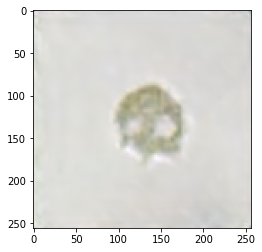

Epoch:  1500
Loss:  0.00037352481740526855


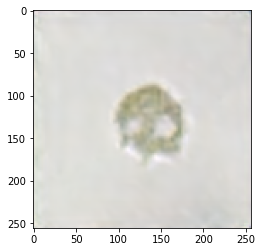

Epoch:  1600
Loss:  0.0003596366150304675


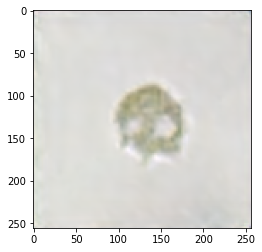

Epoch:  1700
Loss:  0.00035401011700741947


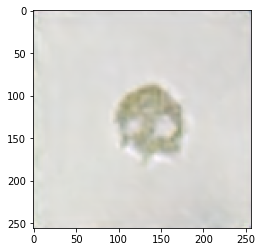

Epoch:  1800
Loss:  0.0003432120429351926


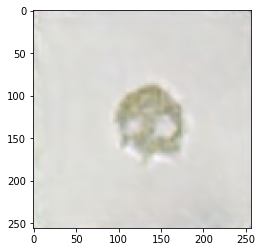

Epoch:  1900
Loss:  0.0003666262491606176


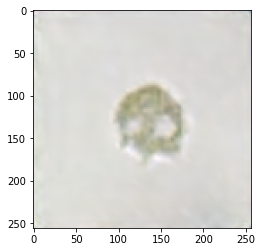

In [36]:


criterion = nn.L1Loss()
learning_rate = 1e-4
# opt1 = torch.optim.Adam({z.detach()}, lr=learning_rate)
opt1 = torch.optim.Adam({z}, lr=1e-1)
opt2 = torch.optim.Adam(generator.parameters(), lr=learning_rate)
# z = Variable(z, requires_grad=True).to(device)
num_steps=2000
y_0 = psfconvolve_torch(test_gt, psf_256)
y_0 = torch.Tensor(y_0).permute(2,0,1).unsqueeze(0).to(device, dtype=torch.float)



for i in range(num_steps):
    opt1.zero_grad()
    opt2.zero_grad()
    generated_image = generator(z)
    


    cycle_ll = psfconvolve_torch(generated_image, psf_256).permute(2,0,1).unsqueeze(0)
    loss = criterion(cycle_ll,y_0)
    loss = loss + total_variation(generated_image, 0.25)
    loss.backward()

    opt1.step()
    opt2.step()

    if i%100==0:
        im = generator(z)[0].permute(1,2,0).detach().cpu()
        print("Epoch: ", i)
        print("Loss: ", float(loss))
        plt.imshow(im/im.max())
        plt.show()

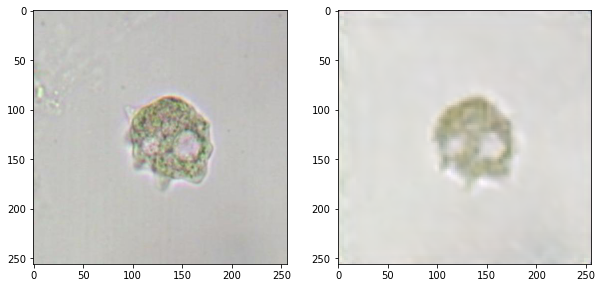

In [37]:
fig1, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(test_gt[0].permute(1,2,0).detach().cpu()/255)
ax[1].imshow(im/im.max())

In [42]:
test_g = test_gt[:,:3,:,:]

truth_np = np.array(test_g[0].permute(1,2,0).detach().cpu()/255)
recon_np = np.array(im/im.max())

In [43]:
from skimage.metrics import structural_similarity

In [44]:
def psnr(x_hat,x_true,maxv=1.):
    x_hat = x_hat.flatten()
    x_true = x_true.flatten()
    mse=np.mean(np.square(x_hat-x_true))
    psnr_ = 10.*np.log(maxv**2/mse)/np.log(10.)
    return psnr_

In [45]:
psnr(recon_np, truth_np)

19.790055115665965

In [47]:
structural_similarity(truth_np,recon_np, multichannel=True)

/home/abeer/anaconda3/envs/torchgpu/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  """Entry point for launching an IPython kernel.


0.93456155

In [ ]:
# import csv
# wordslist = ["i", "loss"]

In [ ]:
# criterion = nn.L1Loss()
# learning_rate = 1e-4
# # opt1 = torch.optim.Adam({z.detach()}, lr=learning_rate)
# opt2 = torch.optim.Adam(generator.parameters(), lr=learning_rate)
# z = Variable(z, requires_grad=True).to(device)
# num_steps=2000

# # Optimize latent space to reconstruct image
# with open("inverse-problem-loss.csv", "w", newline='') as carCountsCsv:
#     for i in range(num_steps):
#         opt1.zero_grad()
#         opt2.zero_grad()
#         generated_image = generator(z)

#     #         loss1 = criterion(generated_image, image.to(device))

#         cycle_ll = psfconvolve_torch(generated_image, psf_256).permute(2,0,1).unsqueeze(0)
#         loss = criterion(cycle_ll, y_0.to(device))

#         loss.backward()

#         opt1.step()
#         opt2.step()

#         # Clip latent space values to [-1, 1] range
#     #     opt_latent_space.data.clamp_(-1, 1)

#         if i%10==0:
#                 writer = csv.writer(carCountsCsv, delimiter=',')
#                 for word in wordslist:
#                     resultCar = [str(i), str(float(loss))]
#                     print(resultCar)
#                     writer.writerow(resultCar)

# #     return generated_image, opt_latent_space, generator